CalledProcessError: Command 'git push -u origin master -f' returned non-zero exit status 1.

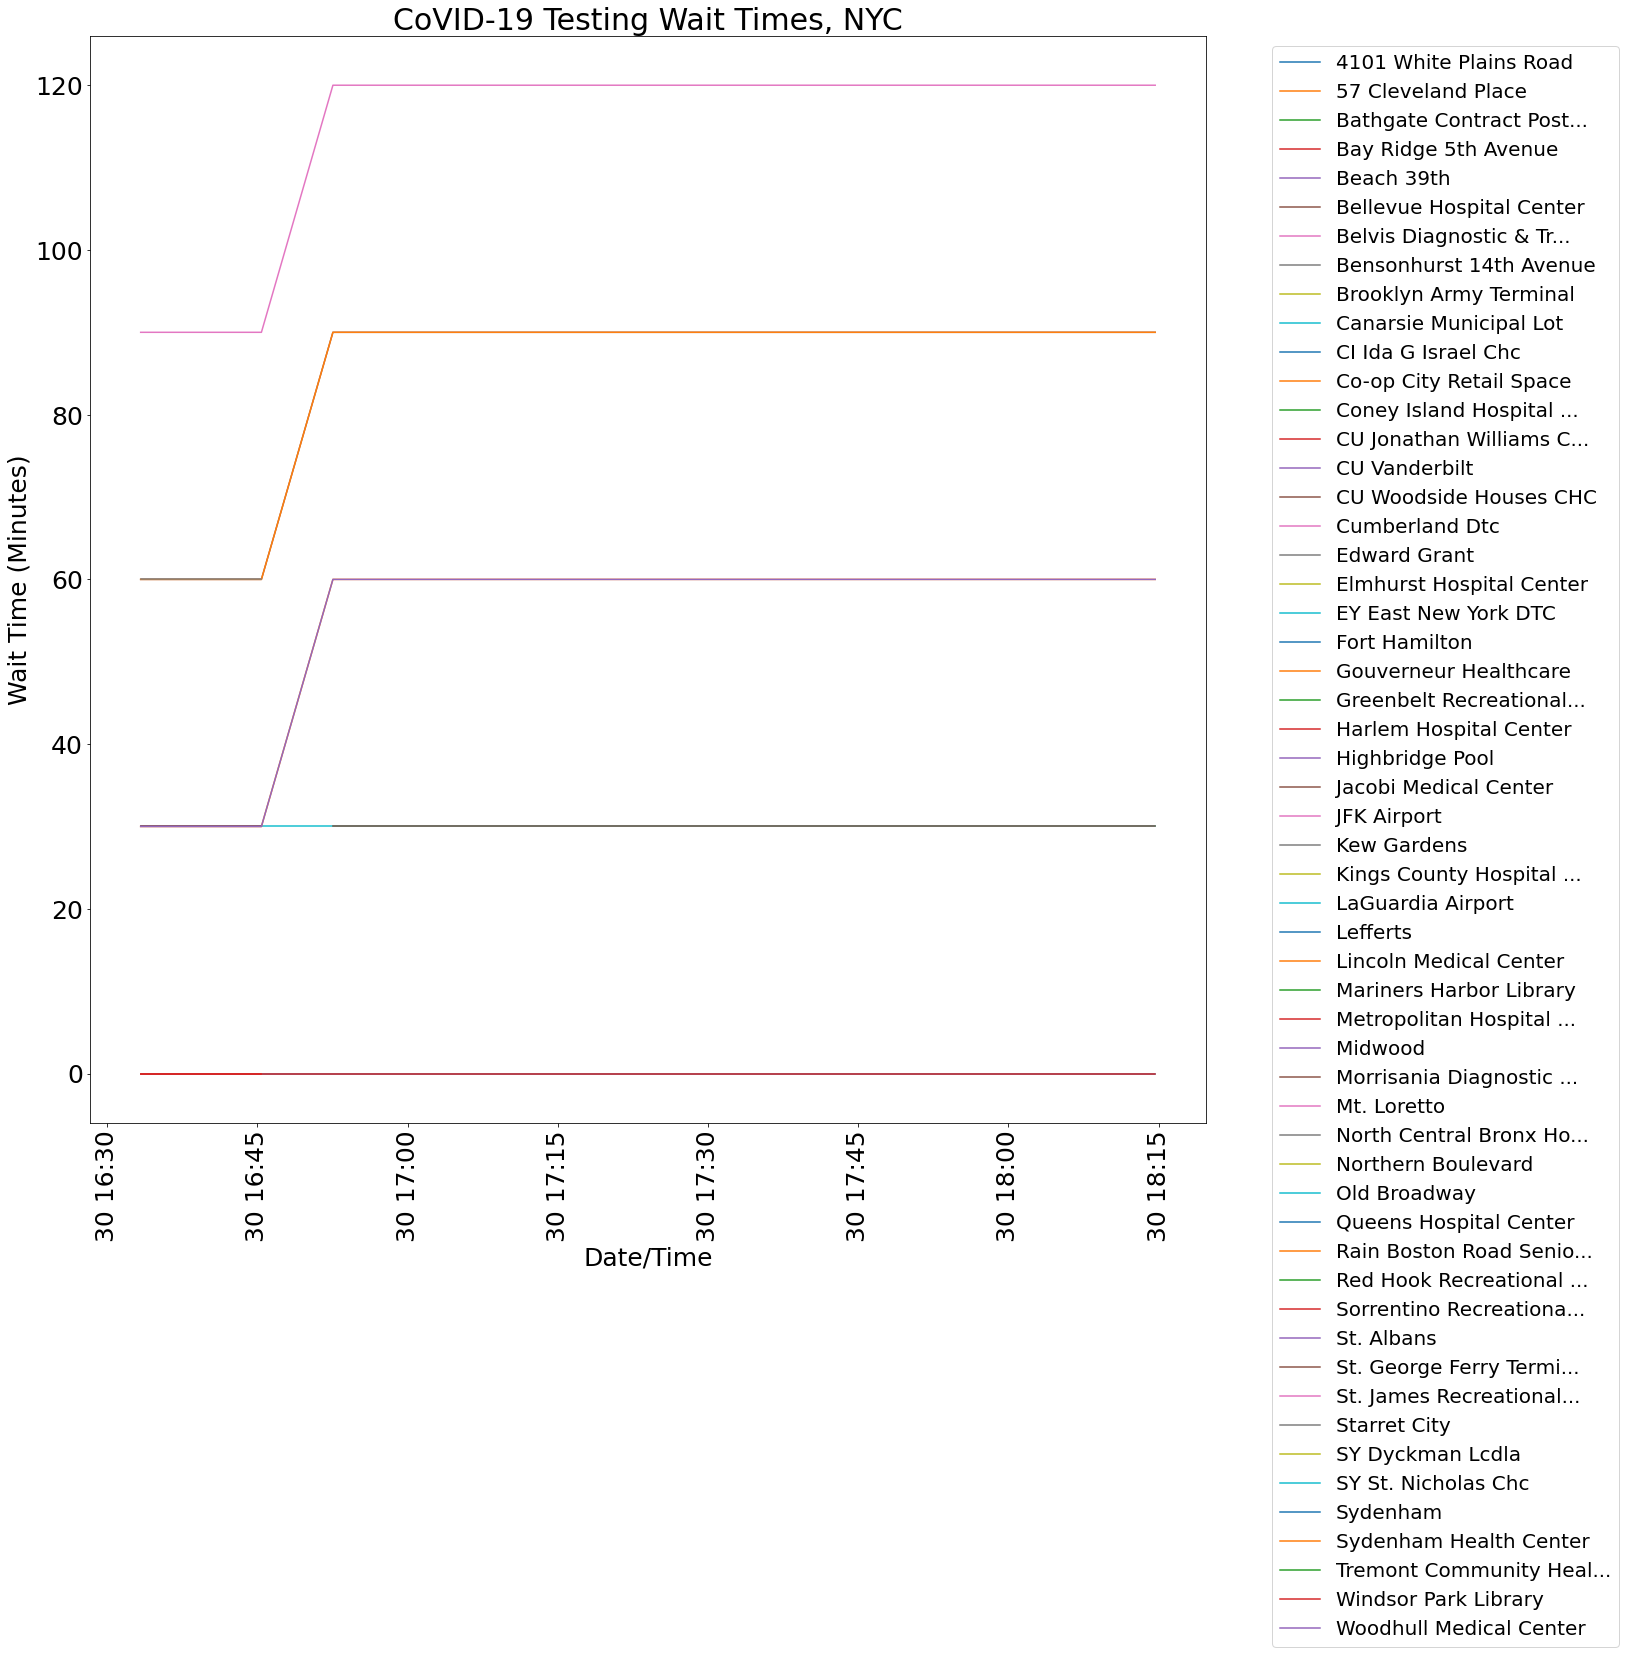

In [9]:
import numpy as np
import urllib.request
import pandas as pd
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
import os.path
import csv 
import matplotlib.pyplot as plt
import datetime
import subprocess as cmd

pdf_url = 'https://hhinternet.blob.core.windows.net/wait-times/testing-wait-times.pdf'
download_name = 'download.pdf'
csv_name = 'wait_times.csv'

# A function to help convert PDFs into text.
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()
    fp.close()
    device.close()
    retstr.close()
    return text

# A function to convert the strings of wait times into actual numbers
def get_numerical_time(text_time):
    if 'Not Reported' in text_time:
        return np.nan
    if 'No Wait' in text_time:
        return 0.0
    if 'Minutes' in text_time:
        dig = [int(s) for s in text_time.split() if s.isdigit()]
        return dig[0]
    if 'Hours' in text_time:
        dig = [int(s) for s in text_time.split() if s.isdigit()]
        hour = dig[0]
        return hour*60
    else:
        print(text_time)
        print('Something has gone awry')
        return np.inf

# This function parses the data from the PDF
def get_data(pdf_url, download_name):
    # Download PDF and convert it to text.
    urllib.request.urlretrieve(pdf_url, download_name)
    text = convert_pdf_to_txt("download.pdf")

    # Cut text before start of actual data: 
    cutind = text.find('196 Albany')
    text = text[cutind:]
    text = text.replace('(cid:415)', 'ti')
    text = text.replace('(cid:425)', 'tt')

    data = text.split('\n')
    while('' in data): 
        data.remove('') 
    data.pop()

    # Break out hospital names and wait times:
    hospitals = data[::2]
    wtimes = data[1::2]

    num_locs = len(hospitals)
    store_times = np.empty([num_locs])

    for i in range(num_locs):
        store_times[i] = get_numerical_time(wtimes[i])
        
    return hospitals, store_times

def datetime_to_float(d):
    return d.timestamp()

def float_to_datetime(fl):
    return datetime.datetime.fromtimestamp(fl)

# This function adds the data to a CSV
def collect_data(pdf_url, download_name, csv_name):
    hospitals, store_times = get_data(pdf_url, download_name)
    # Check if csv exists
    if not os.path.isfile(csv_name):
        with open(csv_name,'w') as f:
            writer = csv.writer(f)
            hospitals.insert(0, 'timestamp')
            writer.writerow(hospitals)
    # Add wait times as last row: 
    with open(csv_name,'a') as f:
            writer = csv.writer(f)
            #store_times.insert(0, datetime.datetime.now())
            store_times = np.insert(store_times, 0, datetime_to_float(datetime.datetime.now()), axis=0)
            writer.writerow(store_times)
    return hospitals
       
# This function reads the CSV and plots the data
def plot_it(csv_name, hospitals):
    raw_out = pd.read_csv(csv_name).to_numpy()

    time_store = []
    for i in range(len(raw_out[:,0])):
        time_store.append(float_to_datetime(raw_out[i,0]))

    plt.figure(figsize=(20, 20))
    for i in range(1,len(raw_out[0,:])-1):
        plt.plot(time_store, raw_out[:,i], label=hospitals[i])

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 20})
    plt.xlabel('Date/Time')
    plt.ylabel('Wait Time (Minutes)')
    plt.title('CoVID-19 Testing Wait Times, NYC')
    plt.xticks(rotation=90)
    plt.rcParams.update({'font.size': 25})
    plt.savefig('wait_times.jpg', bbox_inches='tight')

# This function runs the thing. 
def run_it(pdf_url, download_name, csv_name):
    hospitals = collect_data(pdf_url, download_name, csv_name)
    plot_it(csv_name, hospitals)

run_it(pdf_url, download_name, csv_name)

cp = cmd.run("git add .", check=True, shell=True)
cp = cmd.run("git commit -m 'auto commit'", check=True, shell=True)
cp = cmd.run("git push -u origin master -f", check=True, shell=True)



